# Curate dataset (unfiltered_dataset.csv)

### Imports

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

Get the raw dataset

In [2]:
df = pd.read_csv("../Data Preprocessing/unfiltered_dataset_v4.csv")
# Fixing columns
df.drop(columns=['Imin', 'Isc_x', 'R2_Isc', 'Rsh_x'], inplace=True)
df.rename(columns={'Isc_y': 'Isc', 'Rsh_y': 'Rsh'}, inplace=True)
df['G_spec_int'] = df['G_spec_int']*1.234 # Spectral irradiance up to 4000 nm

C:\Users\syaba\AppData\Local\Temp\ipykernel_20464\3996004961.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data Preprocessing/unfiltered_dataset_v4.csv")


# Data Curating

Drop duplicates

In [3]:
initial_len = df.shape[0]
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
final_len = df.shape[0]
print(f"Original rows: {initial_len}.\nUnique rows: {final_len}.\nDropped {initial_len - final_len} samples.")


Original rows: 1749024.
Unique rows: 1708501.
Dropped 40523 samples.


Timestamp as datetime object

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.sort_values(by='timestamp', inplace=True)

In [5]:
df.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Voc', 'R2_Voc', 'Rs', 'FF', 'V_ini',
       'I_ini', 'APE', 'G_diffuse_start', 'G_diffuse_end', 'Isc', 'NRMSE_Isc',
       'Rsh'],
      dtype='object')

## Physics-based filtering

In [6]:
def clean_by_physics(df):
    clean_df = df.copy()
    
    # ==========================================
    # 1. INITIALIZATION & TYPE CASTING
    # ==========================================
    numeric_columns = clean_df.columns.drop(['filename', 'module_name', 'timestamp'])
    clean_df[numeric_columns] = clean_df[numeric_columns].apply(pd.to_numeric, errors='coerce')
    
    # ==========================================
    # 2. AMBIENT & ENVIRONMENTAL LIMITS
    # ==========================================
    # Temperature constraints
    clean_df.loc[(clean_df['air_temperature'] < -50) | (clean_df['air_temperature'] > 60), 'air_temperature'] = np.nan
    for col in ['module_temperature_center', 'module_temperature_lateral']:
        clean_df.loc[(clean_df[col] < -50) | (clean_df[col] > 150), col] = np.nan

    # Irradiance constraints
    g_cols = [c for c in clean_df.columns if c.startswith('G_')]
    for col in g_cols:
        clean_df.loc[(clean_df[col] < 0) & (clean_df[col] >= -5), col] = 0 
        clean_df.loc[(clean_df[col] < -5) | (clean_df[col] > 4000), col] = np.nan

    # Atmospheric constraints
    clean_df.loc[(clean_df['relative_humidity'] < 0) | (clean_df['relative_humidity'] > 100), 'relative_humidity'] = np.nan
    clean_df.loc[(clean_df['wind_direction'] < 0) | (clean_df['wind_direction'] > 360), 'wind_direction'] = np.nan
    clean_df.loc[(clean_df['wind_speed_ms'] < 0) | (clean_df['wind_speed_ms'] > 75), 'wind_speed_ms'] = np.nan
    clean_df.loc[(clean_df['air_density'] < 0.5) | (clean_df['air_density'] > 2), 'air_density'] = np.nan
    clean_df.loc[(clean_df['abs_pressure'] < 300) | (clean_df['abs_pressure'] > 1200), 'abs_pressure'] = np.nan
    clean_df.loc[(clean_df['APE'] < 1) | (clean_df['APE'] > 2), 'APE'] = np.nan
        
    # ==========================================
    # 3. FUNDAMENTAL ELECTRICAL LIMITS & REGRESSION QUALITY
    # ==========================================
    # Non-negative constraints
    clean_df.loc[clean_df['Isc'] < 0, ['Isc', 'Rsh']] = np.nan # Negative Isc also affects Rsh calculation
    clean_df.loc[clean_df['Voc'] < 0, ['Voc', 'Rs']] = np.nan
    clean_df.loc[clean_df['Impp'] < 0, 'Impp'] = np.nan
    clean_df.loc[clean_df['Vmpp'] < 0, 'Vmpp'] = np.nan    

    # Series and Shunt resistances 
    clean_df.loc[(clean_df['Rsh'] <= 0) | (clean_df['Rsh'] > 500), 'Rsh'] = np.nan
    clean_df.loc[(clean_df['Rs'] < 0) | (clean_df['Rs'] > 100), 'Rs'] = np.nan

    # Regression quality
    clean_df.loc[clean_df['R2_Voc'] < 0, ['R2_Voc', 'Voc', 'Rs']] = np.nan 
    clean_df.loc[(clean_df['NRMSE_Isc'] < 0) | (clean_df['NRMSE_Isc'] > 3), ['NRMSE_Isc', 'Isc', 'Rsh']] = np.nan
    
    # ==========================================
    # 4. RELATIONAL ELECTRICAL LIMITS
    # ==========================================
    i_ceiling = clean_df[['Isc', 'I_ini']].max(axis=1)
    mask_impp_invalid = (clean_df['Impp'] > (i_ceiling * 1.05))
    clean_df.loc[mask_impp_invalid & i_ceiling.notna(), 'Impp'] = np.nan

    mask_vmpp_invalid = (clean_df['Vmpp'] > (clean_df['Voc'] * 1.05))
    clean_df.loc[mask_vmpp_invalid & clean_df['Voc'].notna(), 'Vmpp'] = np.nan

    # ==========================================
    # 5. DATASHEET STC LIMITS (RELATIVE CHECKS)
    # ==========================================
    datasheet_values = pd.read_csv("../datasets/modules_metadata.csv") 
    clean_df = clean_df.merge(datasheet_values[['module_name', 'Voc_stc', 'Isc_stc', 'Pmpp_stc']], on='module_name', how='left')

    voc_rel_diff = (clean_df['Voc'] - clean_df['Voc_stc']).abs() / clean_df['Voc_stc']
    isc_upper_diff = (clean_df['Isc'] - clean_df['Isc_stc']) / clean_df['Isc_stc']

    # Nullify if STC checks fail
    clean_df.loc[voc_rel_diff > 0.5, ['Voc', 'Vmpp']] = np.nan 
    clean_df.loc[isc_upper_diff > 0.5, ['Isc', 'Impp', 'Rsh']] = np.nan

    # ==========================================
    # 6. FINAL DERIVED CALCULATIONS 
    # ==========================================
    # Calculate Pmpp ONLY from validated Vmpp and Impp
    clean_df['Pmpp'] = clean_df['Vmpp'] * clean_df['Impp']
    
    # Apply Pmpp STC upper bound and non-negative check
    pmpp_upper_diff = (clean_df['Pmpp'] - clean_df['Pmpp_stc']) / clean_df['Pmpp_stc']
    clean_df.loc[(clean_df['Pmpp'] < 0) | (pmpp_upper_diff > 0.5), 'Pmpp'] = np.nan

    # Calculate FF 
    clean_df['FF'] = clean_df['Pmpp'] / (clean_df['Voc'] * clean_df['Isc'])
    clean_df.loc[(clean_df['FF'] <= 0) | (clean_df['FF'] >= 1.0), ['FF', 'Rsh', 'Rs']] = np.nan

    return clean_df.drop(columns=['Voc_stc', 'Isc_stc', 'Pmpp_stc'])


df_physics = clean_by_physics(df)

In [7]:
def summarize_cleaning(df_before, df_after):
    # List before and after cleaning per column
    before_counts = df_before.count()
    after_counts = df_after.count()

    # 2. Create the summary DataFrame
    stats_df = pd.DataFrame({
        'Before': before_counts,
        'After': after_counts,
        'Removed': before_counts - after_counts
    })

    # 3. Add a percentage column 
    stats_df['% Removed'] = ((stats_df['Removed'] / stats_df['Before']) * 100).round(2)

    # Display the results
    print(stats_df[stats_df['Removed'] > 0].sort_values('Removed', ascending=False))
    print(f"Summary: {before_counts.sum() - after_counts.sum()} datapoints removed. {(before_counts.sum() - after_counts.sum())/before_counts.sum()*100:.2f}% of total data.")

In [8]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
module_temperature_lateral  1708501  1550480   158021       9.25
APE                         1616183  1494302   121881       7.54
Rs                          1708282  1653821    54461       3.19
Rsh                         1705413  1653040    52373       3.07
FF                          1708094  1664736    43358       2.54
Pmpp                        1708501  1668181    40320       2.36
Impp                        1708501  1671869    36632       2.14
Isc                         1705413  1672596    32817       1.92
Vmpp                        1708501  1703822     4679       0.27
Voc                         1708282  1704188     4094       0.24
abs_pressure                1708501  1704418     4083       0.24
module_temperature_center   1708501  1705213     3288       0.19
air_density                 1708501  1706849     1652       0.10
NRMSE_Isc                   1705413  1704980      433       0.03
G_horiz_start            

## Analyze data distribution

In [9]:
elec_cols = ['Vmpp', 'Impp', 'Pmpp', 'Voc', 'Isc', 'FF', 'Rsh', 'Rs', 'R2_Voc', 'NRMSE_Isc', 'V_ini', 'I_ini']
df_ambient = df_physics.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_elec = df_physics[elec_cols]
# df_ambient.describe().T

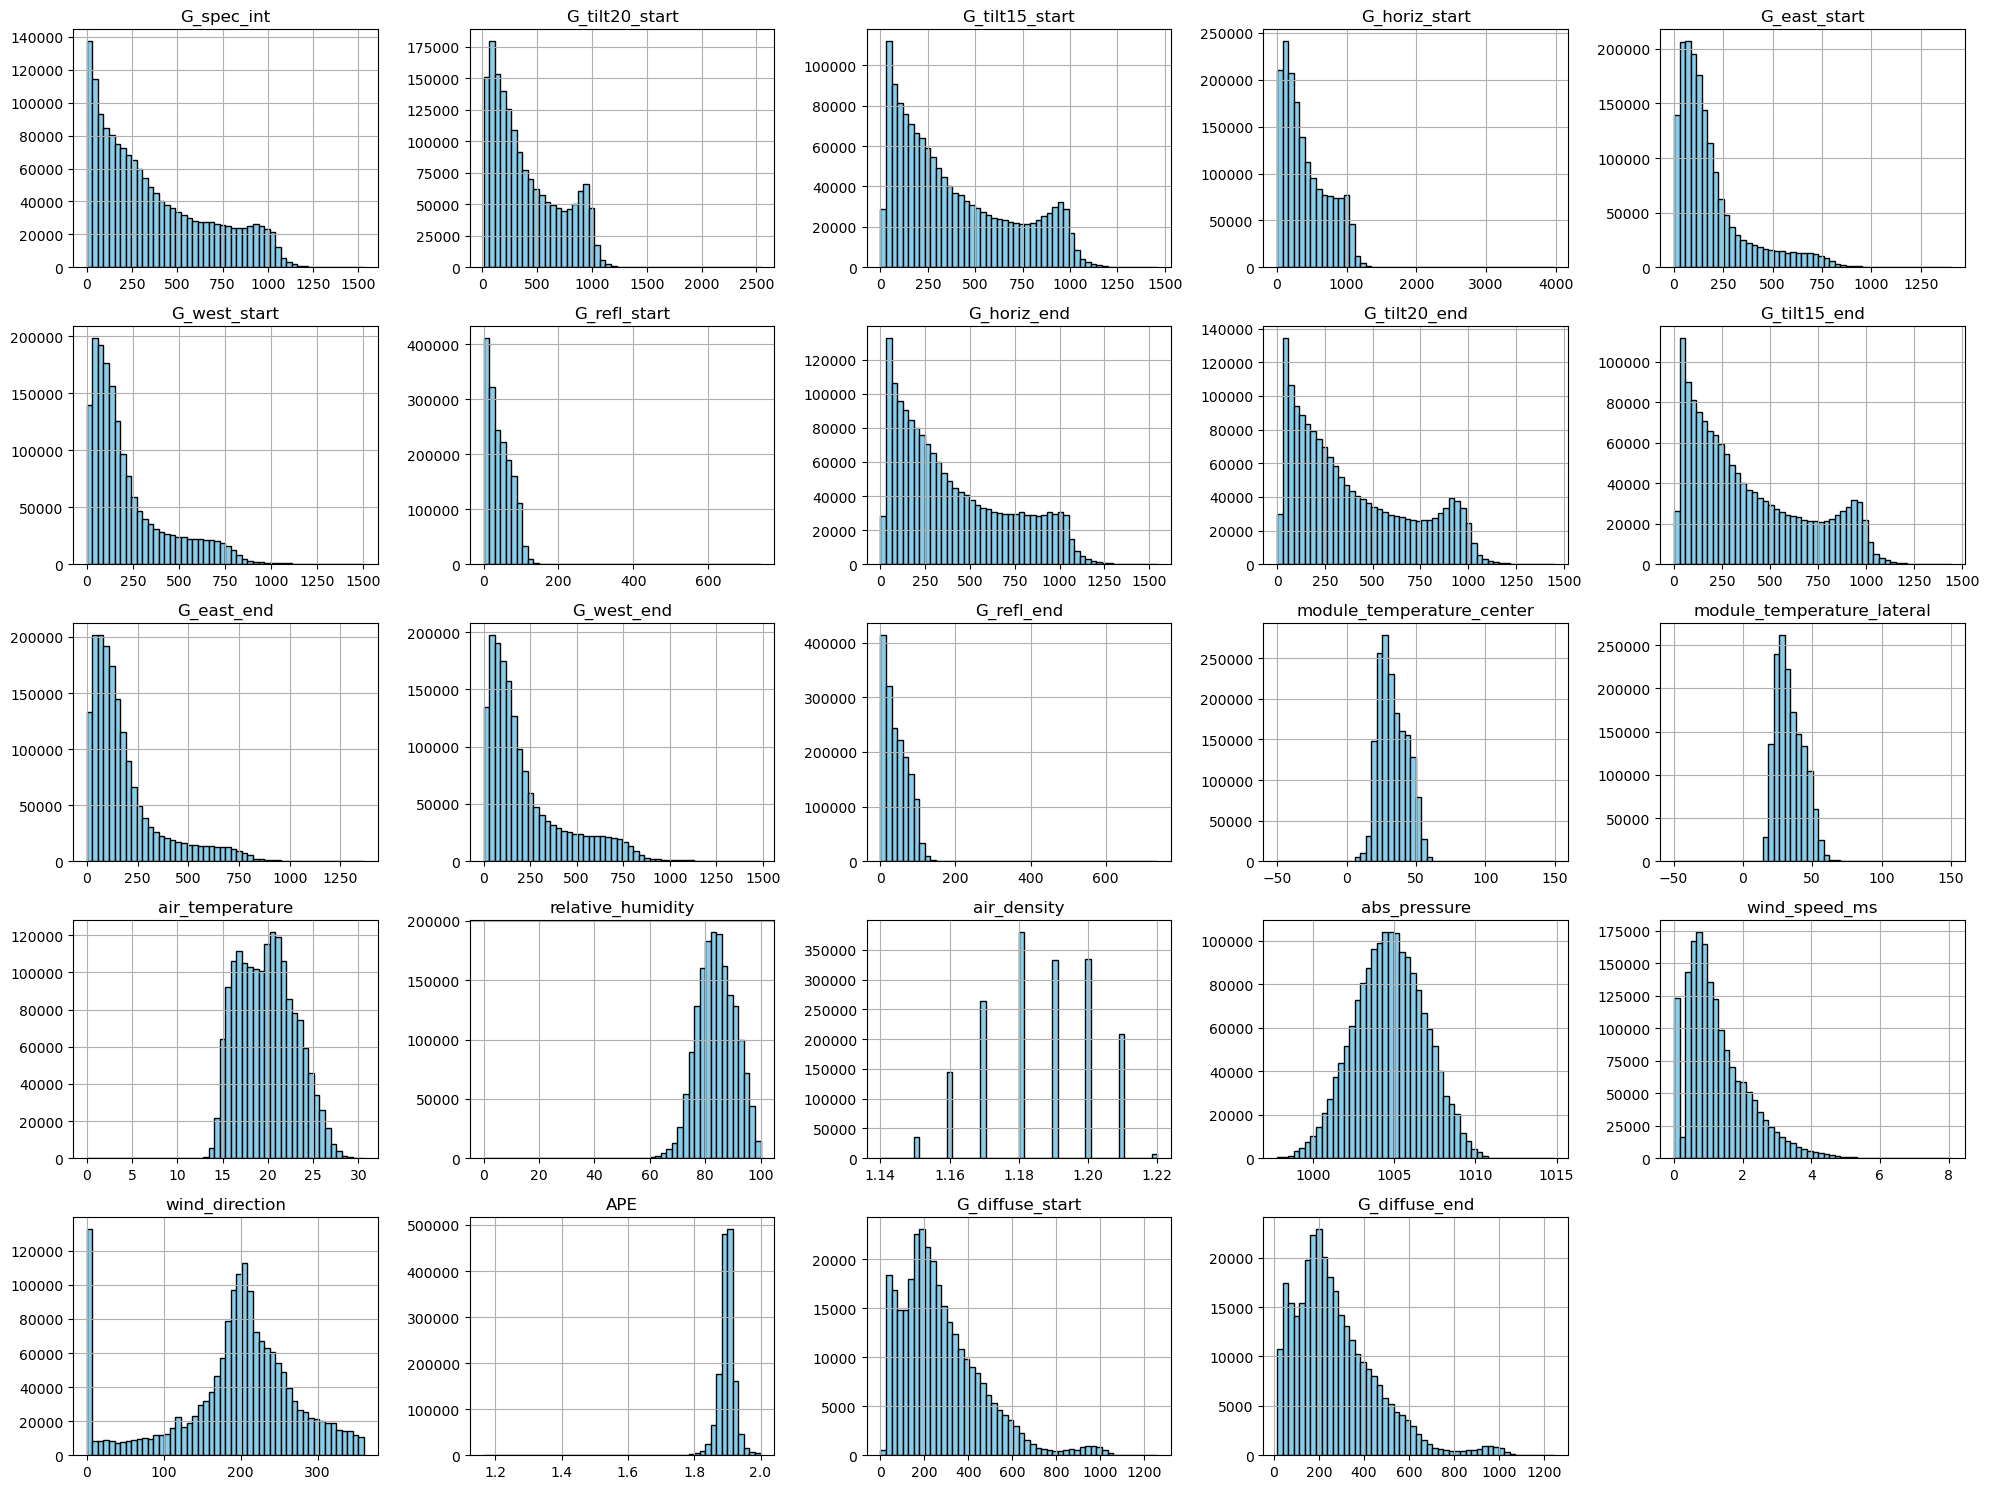

In [10]:
# Plot all numeric columns
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

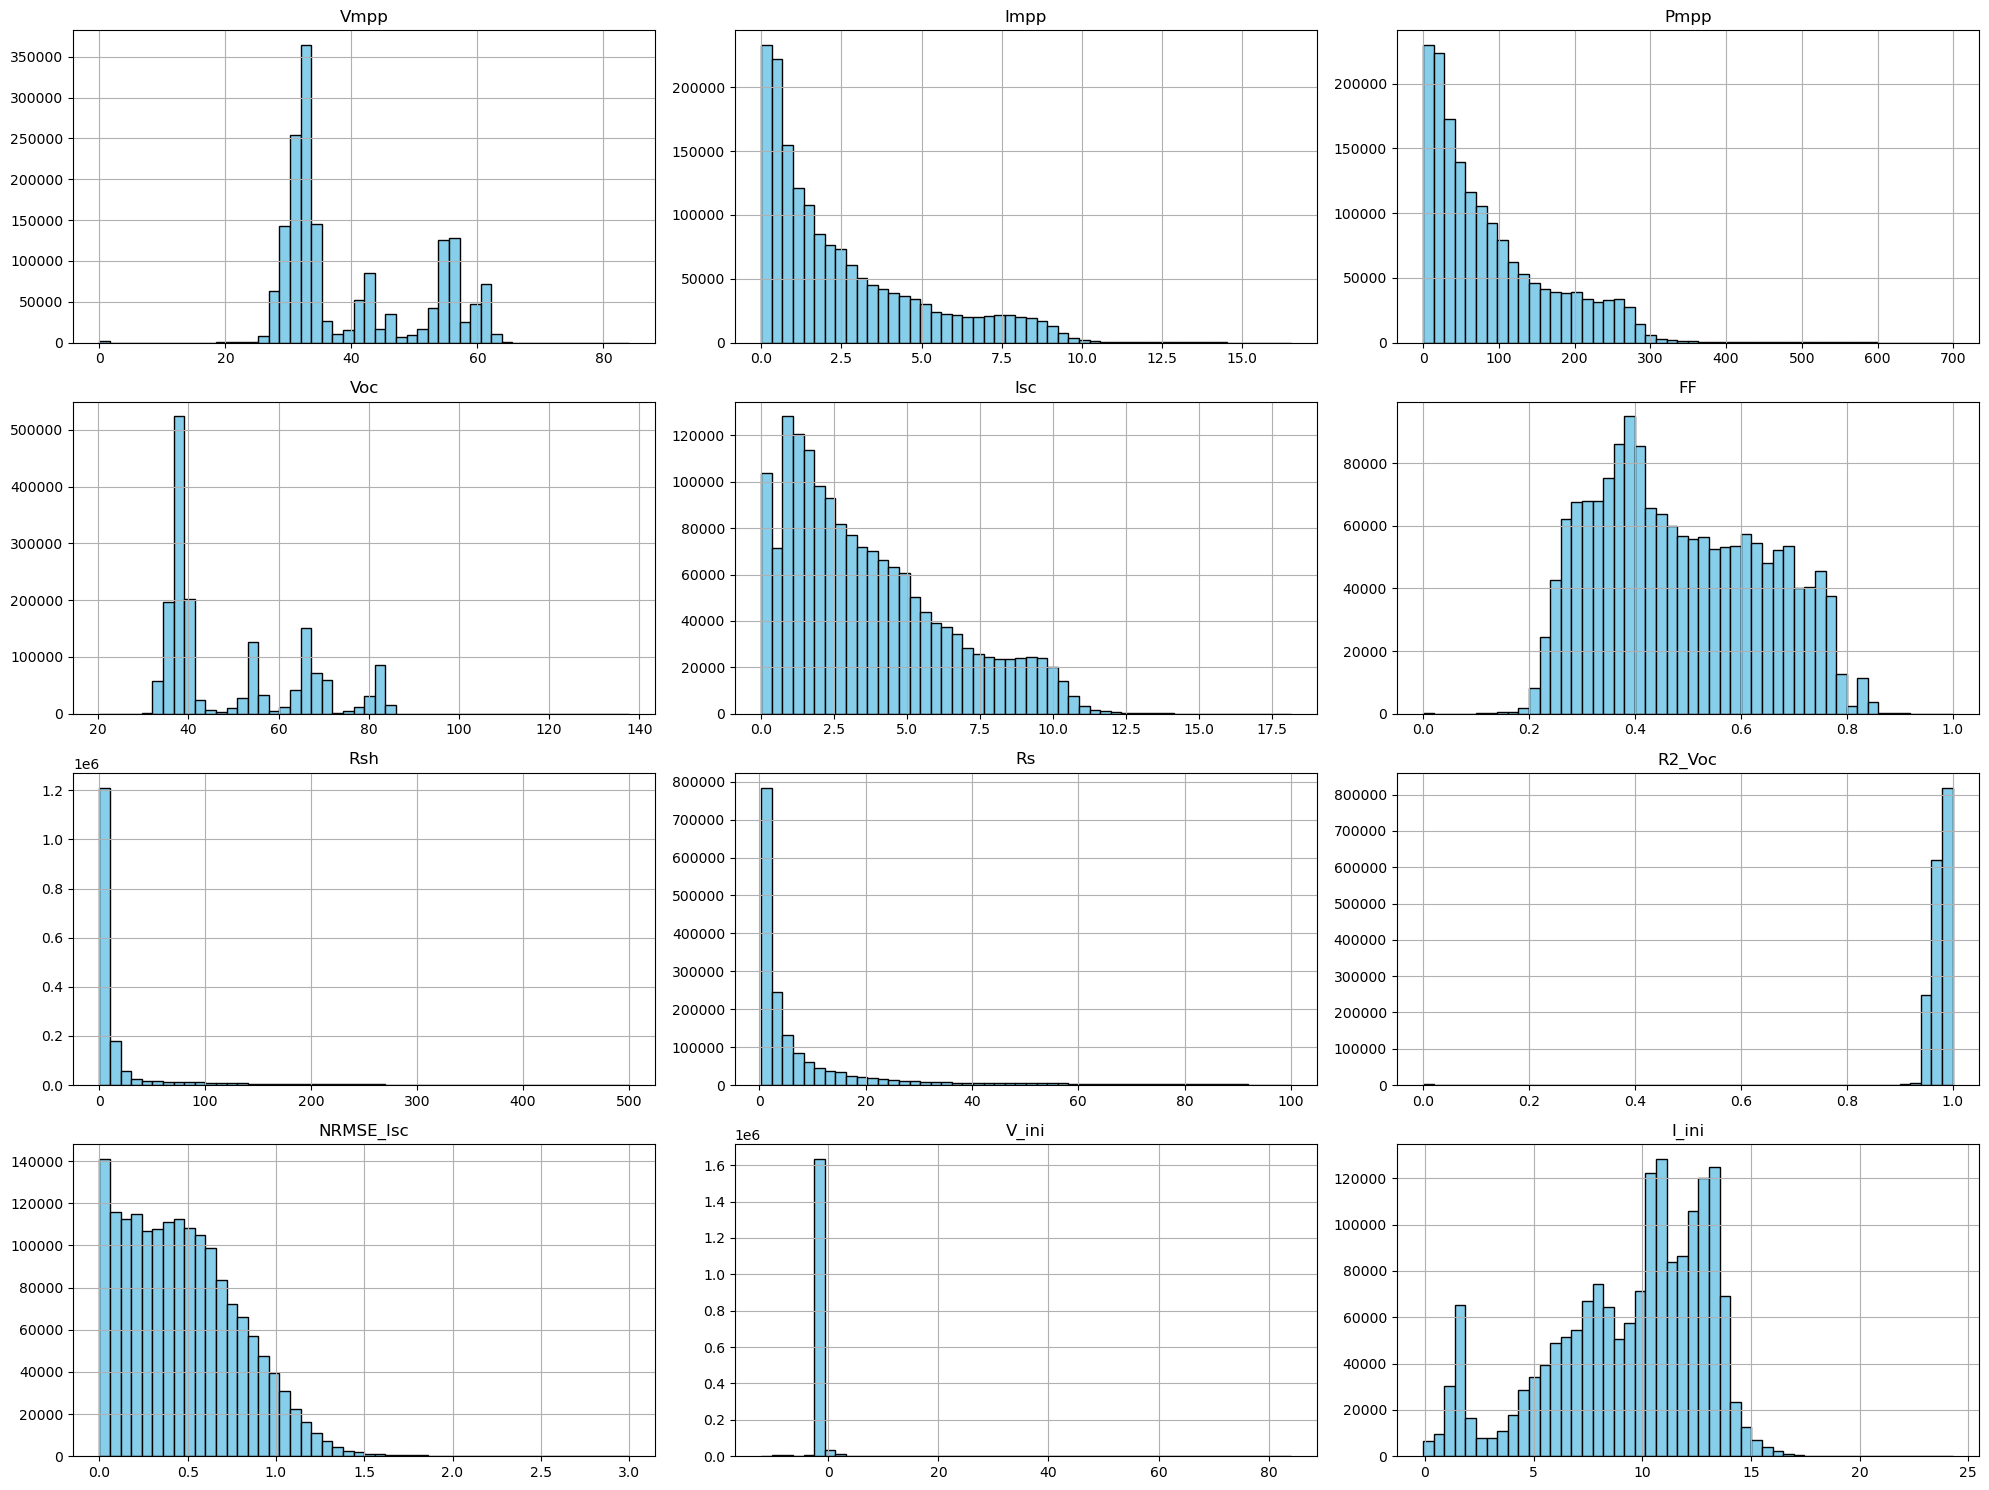

In [11]:
df_elec.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [12]:
df_elec.describe().T

,count,mean,std,min,25%,50%,75%,max
Vmpp,1703822.0,40.132736,11.180087,0.000000e+00,31.743656,33.708343,53.337977,84.053757
Impp,1671869.0,2.546134,2.470019,0.000000e+00,0.595388,1.639898,3.808011,16.518959
Pmpp,1668181.0,89.769334,80.369537,0.000000e+00,25.356734,63.884224,133.404565,699.031523
Voc,1704188.0,49.409529,15.622490,2.029353e+01,37.451800,39.626326,65.129826,137.699142
Isc,1672596.0,3.672527,2.746076,7.726963e-05,1.433549,3.022125,5.319853,18.129278
FF,1664736.0,0.486645,0.157144,1.884010e-13,0.359088,0.465503,0.615587,0.999935
Rsh,1653040.0,21.632250,52.206779,3.505967e-01,2.975387,5.017439,11.616036,499.994248
Rs,1653821.0,8.503350,14.996451,3.416244e-01,1.010901,2.575749,8.196874,99.999675
R2_Voc,1708282.0,0.970470,0.073250,2.001135e-09,0.964496,0.978981,0.988916,0.999981
NRMSE_Isc,1704980.0,0.476243,0.327445,1.335989e-06,0.208995,0.442609,0.689870,2.999173


## Statistics-based filtering

### Applying IQR filtering to normal-distributed variables

In [13]:
normal_looking = ['module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure', 'FF', 'APE']

df_normal = df_physics[normal_looking]

In [14]:
def clean_by_iqr(df, multiplier=3.0):
    clean_df = df.copy()
    
    for col in clean_df.columns:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        
        # Replace outliers with NaN
        clean_df.loc[(clean_df[col] < lower_bound) | (clean_df[col] > upper_bound), col] = np.nan
        
    return clean_df
    
df_normal_cleaned = clean_by_iqr(df_normal, multiplier=1.5) 

In [15]:
summarize_cleaning(df_normal, df_normal_cleaned)
df_physics[normal_looking] = df_normal_cleaned

                             Before    After  Removed  % Removed
APE                         1494302  1401146    93156       6.23
module_temperature_lateral  1550480  1541150     9330       0.60
module_temperature_center   1705213  1699537     5676       0.33
relative_humidity           1708491  1703442     5049       0.30
abs_pressure                1704418  1701842     2576       0.15
air_temperature             1708489  1707835      654       0.04
Summary: 116441 datapoints removed. 0.88% of total data.


## Transforming and applying IQR filter

Transforming irradiance and wind speed measurements to account for right skewdness before doing IQR filtering

In [16]:
def clean_skewed_outliers(df, multiplier=3.0):
    clean_df = df.copy()
    for col in clean_df.columns:
        # 1. Transform to log-space to normalize the "Right Skew"
        series_log = np.log1p(clean_df[col])
        
        # 2. Calculate IQR on the LOG-transformed data
        Q1 = series_log.quantile(0.25)
        Q3 = series_log.quantile(0.75)
        IQR = Q3 - Q1
        
        # 3. Define bounds in log-space
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        
        # 4. Create a mask of outliers
        # We do NOT drop them yet; we just identify their locations
        is_outlier = (series_log < lower) | (series_log > upper)
        
        # 5. Nullify the outliers in the ORIGINAL (untransformed) scale
        clean_df.loc[is_outlier, col] = np.nan
        
    return clean_df

# Now apply it
skewed_cols = [col for col in df_physics.columns if col.startswith('G_')] + ['wind_speed_ms']
df_skewed_cleaned = clean_skewed_outliers(df_physics[skewed_cols], multiplier=1.5)

In [17]:
summarize_cleaning(df_physics[skewed_cols], df_skewed_cleaned)
# Re-attach to original
df_physics[skewed_cols] = df_skewed_cleaned

                  Before    After  Removed  % Removed
G_spec_int       1616170  1500062   116108       7.18
G_diffuse_start   315066   307805     7261       2.30
G_diffuse_end     315066   307838     7228       2.29
wind_speed_ms    1708501  1704341     4160       0.24
G_east_end       1708501  1706646     1855       0.11
G_east_start     1708501  1706726     1775       0.10
G_west_start     1708501  1707716      785       0.05
G_west_end       1708501  1707732      769       0.05
G_horiz_end      1708501  1707988      513       0.03
G_tilt15_start   1439439  1439030      409       0.03
G_tilt15_end     1439439  1439044      395       0.03
G_tilt20_end     1708501  1708135      366       0.02
G_refl_end       1708501  1708307      194       0.01
G_refl_start     1708501  1708315      186       0.01
G_horiz_start    1708371  1708319       52       0.00
G_tilt20_start   1708501  1708500        1       0.00
Summary: 142057 datapoints removed. 0.59% of total data.


# Final Visualization

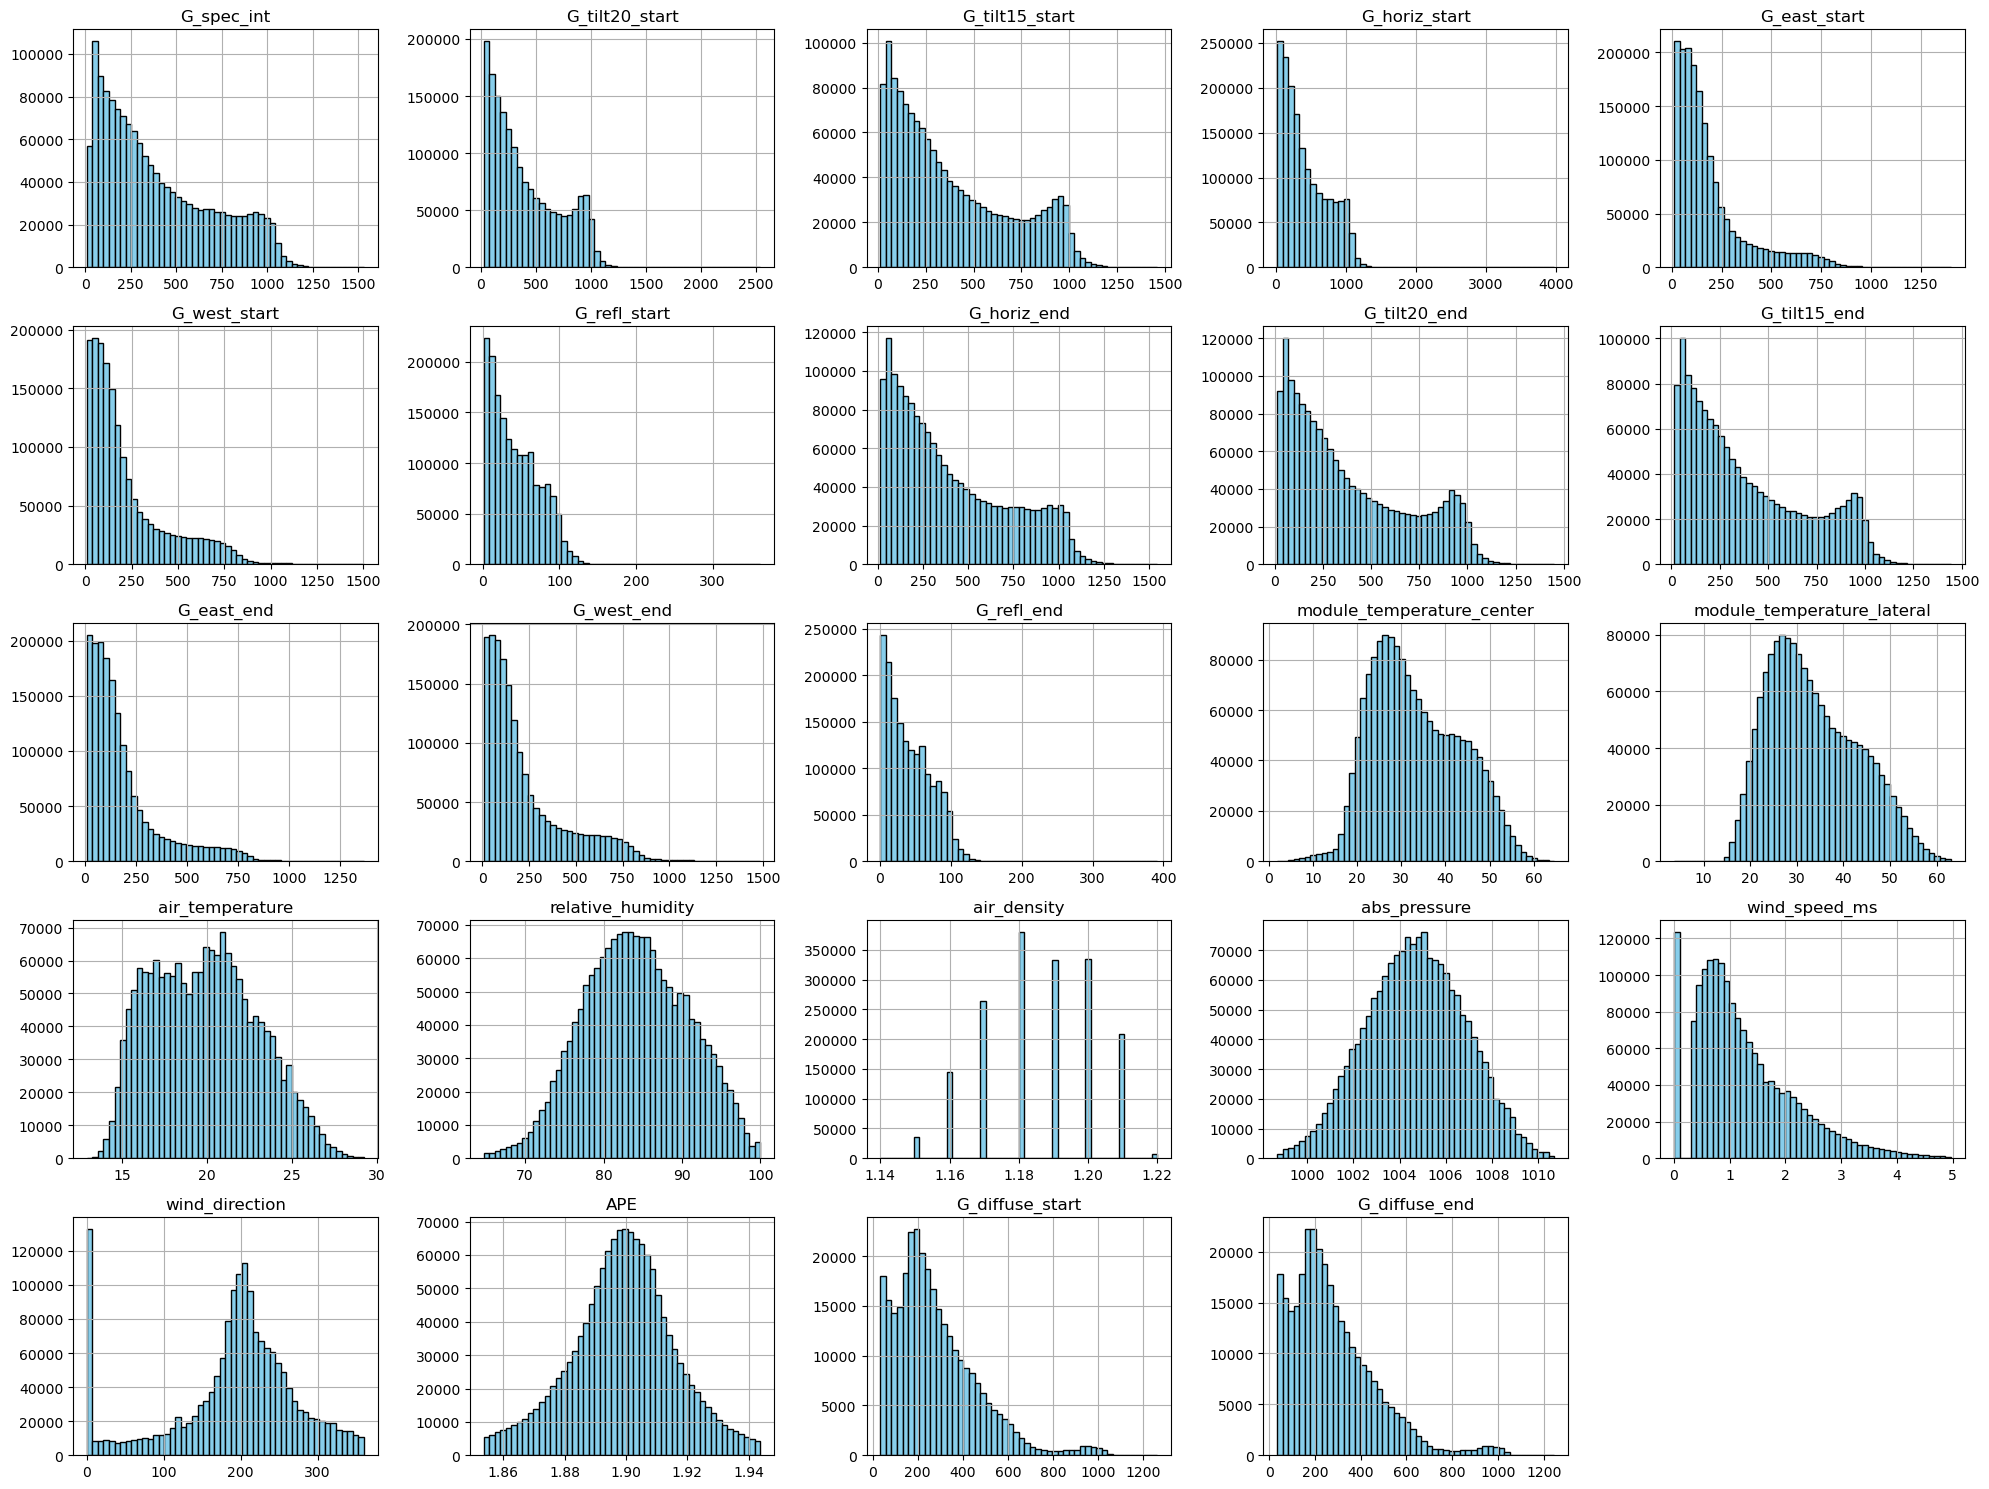

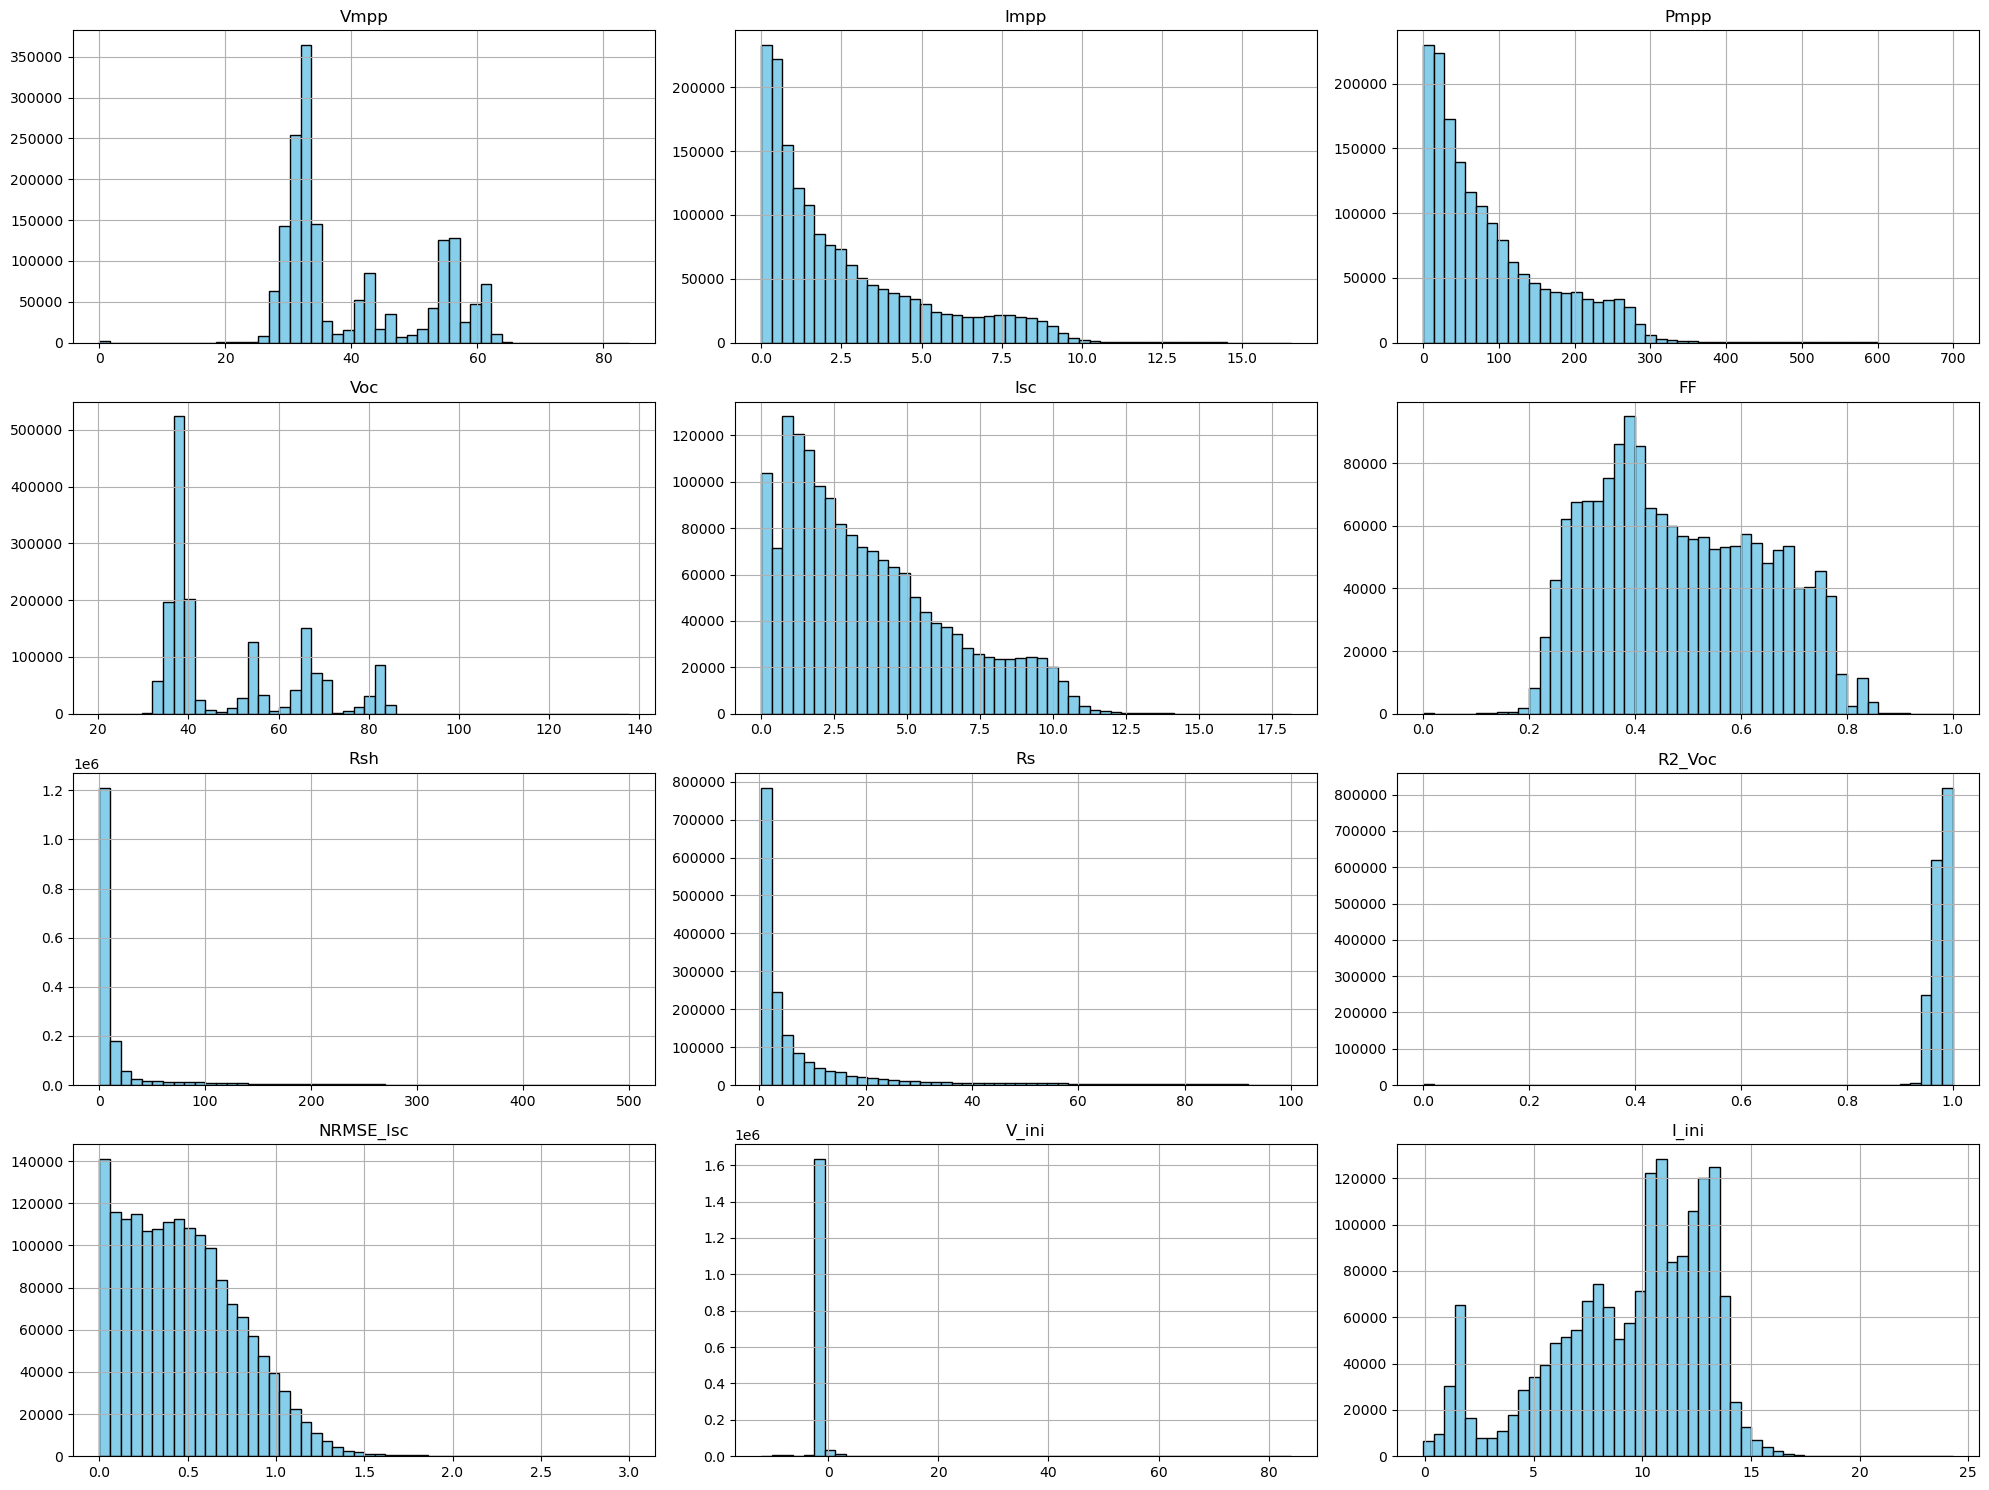

In [18]:
df_ambient = df_physics.drop(columns=['filename', 'module_name', 'timestamp'] + elec_cols)
df_elec = df_physics[elec_cols]
# Plot all numeric columns
df_ambient.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()
df_elec.hist(bins=50, figsize=(20, 15), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

In [19]:
df_physics.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,1708501,2024-01-04 04:18:24.911891712,2022-01-01 06:30:01,2023-01-06 14:55:19,2024-01-09 11:38:06,2024-12-29 12:35:19,2025-12-31 15:05:01,NaN
Vmpp,1703822.0,40.132736,0.0,31.743656,33.708343,53.337977,84.053757,11.180087
Impp,1671869.0,2.546134,0.0,0.595388,1.639898,3.808011,16.518959,2.470019
Pmpp,1668181.0,89.769334,0.0,25.356734,63.884224,133.404565,699.031523,80.369537
G_spec_int,1500062.0,398.12953,8.851235,145.559164,313.869272,615.265368,1529.526324,299.17347
G_tilt20_start,1708500.0,401.502076,23.22,143.0575,312.13,630.28,2538.77,302.701271
G_tilt15_start,1439030.0,390.242248,13.15,134.66,301.09,611.49,1460.32,300.715799
G_horiz_start,1708319.0,421.361085,16.72,153.61,331.13,654.66,3978.53,316.03555
G_east_start,1706726.0,187.938165,9.95,67.28,128.72,229.5,1402.55,180.518042
G_west_start,1707716.0,228.454681,7.98,74.28,148.69,309.33,1502.25,214.837375


# Final dataset 

In [20]:
summarize_cleaning(df, df_physics)

                             Before    After  Removed  % Removed
APE                         1616183  1401146   215037      13.31
module_temperature_lateral  1708501  1541150   167351       9.80
G_spec_int                  1616184  1500062   116122       7.18
Rs                          1708282  1653821    54461       3.19
Rsh                         1705413  1653040    52373       3.07
FF                          1708094  1664736    43358       2.54
Pmpp                        1708501  1668181    40320       2.36
Impp                        1708501  1671869    36632       2.14
Isc                         1705413  1672596    32817       1.92
module_temperature_center   1708501  1699537     8964       0.52
G_diffuse_start              315066   307805     7261       2.30
G_diffuse_end                315066   307838     7228       2.29
abs_pressure                1708501  1701842     6659       0.39
relative_humidity           1708501  1703442     5059       0.30
Vmpp                     

In [21]:
df_final = df_physics.reset_index(drop=True)

In [22]:
df_final.describe().T

,count,mean,min,25%,50%,75%,max,std
timestamp,1708501,2024-01-04 04:18:24.911891712,2022-01-01 06:30:01,2023-01-06 14:55:19,2024-01-09 11:38:06,2024-12-29 12:35:19,2025-12-31 15:05:01,NaN
Vmpp,1703822.0,40.132736,0.0,31.743656,33.708343,53.337977,84.053757,11.180087
Impp,1671869.0,2.546134,0.0,0.595388,1.639898,3.808011,16.518959,2.470019
Pmpp,1668181.0,89.769334,0.0,25.356734,63.884224,133.404565,699.031523,80.369537
G_spec_int,1500062.0,398.12953,8.851235,145.559164,313.869272,615.265368,1529.526324,299.17347
G_tilt20_start,1708500.0,401.502076,23.22,143.0575,312.13,630.28,2538.77,302.701271
G_tilt15_start,1439030.0,390.242248,13.15,134.66,301.09,611.49,1460.32,300.715799
G_horiz_start,1708319.0,421.361085,16.72,153.61,331.13,654.66,3978.53,316.03555
G_east_start,1706726.0,187.938165,9.95,67.28,128.72,229.5,1402.55,180.518042
G_west_start,1707716.0,228.454681,7.98,74.28,148.69,309.33,1502.25,214.837375


In [23]:
df_final.head(10)

,filename,module_name,timestamp,Vmpp,Impp,Pmpp,G_spec_int,G_tilt20_start,G_tilt15_start,G_horiz_start,G_east_start,G_west_start,G_refl_start,G_horiz_end,G_tilt20_end,G_tilt15_end,G_east_end,G_west_end,G_refl_end,module_temperature_center,module_temperature_lateral,air_temperature,relative_humidity,air_density,abs_pressure,wind_speed_ms,wind_direction,Voc,R2_Voc,Rs,FF,V_ini,I_ini,APE,G_diffuse_start,G_diffuse_end,Isc,NRMSE_Isc,Rsh
0,VBHN330_01_01_2022_06_30_01.csv,VBHN330,2022-01-01 06:30:01,NaN,0.113265,NaN,23.218863,26.28,NaN,27.32,11.37,11.25,3.20,22.22,22.13,NaN,11.40,11.28,3.19,21.17,20.38,19.17,95.08,1.19,1003.87,0.53,317.01,NaN,0.857445,NaN,NaN,-2.077111,8.303975,NaN,NaN,NaN,0.359237,1.628118,18.149570
1,NAF128GK_01_01_2022_06_30_37.csv,NAF128GK,2022-01-01 06:30:37,36.339943,0.058908,2.140713,23.935465,26.01,NaN,26.95,11.67,11.55,3.36,23.26,22.82,NaN,11.88,11.65,3.42,20.87,20.09,19.19,95.05,1.19,1003.95,1.35,40.54,47.480906,0.988244,NaN,0.369658,-0.832341,1.469773,NaN,NaN,NaN,0.121966,1.099921,92.906089
2,QPEAK315_01_01_2022_06_31_16.csv,QPEAK315,2022-01-01 06:31:16,29.964212,0.195919,5.870558,24.598475,25.89,NaN,26.89,11.92,11.75,3.42,23.73,23.16,NaN,12.00,11.71,3.51,20.37,20.05,19.19,95.05,1.19,1003.95,0.59,339.69,34.860217,0.958309,15.247258,0.359020,-1.276841,4.394951,NaN,NaN,NaN,0.469062,0.942297,13.624814
3,LG370Q1C_01_01_2022_06_31_35.csv,LG370Q1C,2022-01-01 06:31:35,29.967451,0.185282,5.552429,24.860619,26.28,NaN,27.38,12.09,11.79,3.54,24.18,23.64,NaN,12.06,11.83,3.51,22.06,20.67,19.26,95.17,1.19,1003.89,0.46,320.94,36.688569,0.962679,19.248764,0.291664,-1.297689,4.787510,1.941752,NaN,NaN,0.518882,0.938532,12.798314
4,LG345N1C_01_01_2022_06_31_53.csv,LG345N1C,2022-01-01 06:31:53,30.807138,0.216801,6.679018,25.067576,26.53,NaN,27.65,12.18,11.91,3.55,24.30,23.71,NaN,12.22,11.88,3.48,20.88,NaN,19.26,95.17,1.19,1003.89,0.64,321.56,36.065147,0.958082,14.490173,0.324996,-1.317866,5.724658,1.939822,NaN,NaN,0.569832,1.024513,10.590272
5,GSA060_01_01_2022_06_32_11.csv,GSA060,2022-01-01 06:32:11,53.182745,0.021837,1.161352,25.219610,28.28,NaN,28.94,12.24,11.96,3.50,24.37,24.33,NaN,12.43,12.00,3.45,21.05,20.89,19.26,95.17,1.19,1003.89,1.05,328.21,86.083433,0.991089,NaN,0.331859,-0.862577,0.839067,1.938326,NaN,NaN,0.040653,1.116875,NaN
6,CDF1150A1_01_01_2022_06_33_11.csv,CDF1150A1,2022-01-01 06:33:11,35.898239,0.033540,1.204027,25.420068,27.79,NaN,28.94,12.50,12.06,3.54,24.65,24.31,NaN,12.60,12.16,3.51,21.18,20.86,19.23,94.94,1.19,1003.98,0.36,332.39,54.374985,0.992835,NaN,0.325243,-0.842571,0.766343,1.937075,NaN,NaN,0.068081,0.811963,275.398160
7,CS3K320MB-V_01_01_2022_06_34_11.csv,CS3K320MB-V,2022-01-01 06:34:11,30.133344,0.166733,5.024223,25.397348,26.75,NaN,27.83,12.62,12.27,3.60,24.46,23.97,NaN,12.60,12.24,3.63,25.27,25.17,19.19,94.93,1.19,1004.00,0.75,320.42,34.474057,0.957630,17.475601,0.362688,-1.272395,3.303721,1.939462,NaN,NaN,0.401830,0.871264,15.493395
8,CS3K320MB-T_01_01_2022_06_34_29.csv,CS3K320MB-T,2022-01-01 06:34:29,29.823086,0.225905,6.737184,25.459511,26.88,NaN,28.16,12.63,12.17,3.59,24.71,24.08,NaN,12.63,12.24,3.69,26.17,26.05,19.16,94.98,1.19,1003.94,0.46,322.99,34.988854,0.958861,13.483851,0.373294,-1.245545,3.350677,1.939556,NaN,NaN,0.515819,0.771445,12.668190
9,VBHN330_01_01_2022_06_35_01.csv,VBHN330,2022-01-01 06:35:01,NaN,0.118800,NaN,25.655074,29.25,NaN,30.23,12.74,12.41,3.70,24.44,24.38,NaN,12.74,12.38,3.62,21.24,20.49,19.16,94.98,1.19,1003.94,0.00,0.00,NaN,0.974991,NaN,NaN,-1.684439,2.662584,1.939855,NaN,NaN,0.221862,0.889913,55.938151


In [24]:
df_final.columns

Index(['filename', 'module_name', 'timestamp', 'Vmpp', 'Impp', 'Pmpp',
       'G_spec_int', 'G_tilt20_start', 'G_tilt15_start', 'G_horiz_start',
       'G_east_start', 'G_west_start', 'G_refl_start', 'G_horiz_end',
       'G_tilt20_end', 'G_tilt15_end', 'G_east_end', 'G_west_end',
       'G_refl_end', 'module_temperature_center', 'module_temperature_lateral',
       'air_temperature', 'relative_humidity', 'air_density', 'abs_pressure',
       'wind_speed_ms', 'wind_direction', 'Voc', 'R2_Voc', 'Rs', 'FF', 'V_ini',
       'I_ini', 'APE', 'G_diffuse_start', 'G_diffuse_end', 'Isc', 'NRMSE_Isc',
       'Rsh'],
      dtype='object')

In [25]:
df_final.drop('filename', axis=1, inplace=True)

In [26]:
# Define the logical column order
new_column_order = [
    # --- 1. ID & Metadata ---
    'module_name', 'timestamp',

    # --- 2. Electrical Parameters (IV Curve) ---
    'Vmpp', 'Impp', 'Pmpp',
    'Isc', 'Voc', 'FF',
    'Rsh', 'Rs',
    'NRMSE_Isc', 'R2_Voc',  # Quality/Fitting metrics
    'V_ini', 'I_ini',

    # --- 3. Spectral & Irradiance (The "Gs") ---
    'G_spec_int',        # Primary spectral integral
    'APE',               # Average Photon Energy (placed after G_spec_int as requested)
    
    # Grouping G sensors by type (Start/End pairs)
    'G_tilt20_start', 'G_tilt20_end',
    'G_tilt15_start', 'G_tilt15_end',
    'G_horiz_start',  'G_horiz_end',
    'G_diffuse_start','G_diffuse_end',
    'G_east_start',   'G_east_end',
    'G_west_start',   'G_west_end',
    'G_refl_start',   'G_refl_end',

    # --- 4. Module Temperature ---
    'module_temperature_center', 
    'module_temperature_lateral',

    # --- 5. Environmental / Weather ---
    'air_temperature', 
    'relative_humidity', 
    'air_density', 
    'abs_pressure', 
    'wind_speed_ms', 
    'wind_direction'
]

# Reorder the DataFrame
df_final = df_final[new_column_order]

# Save to CSV
df_final.to_csv("PV_dataset.csv", index=False)

# Module metadata

In [27]:
df_final = pd.read_csv("PV_dataset.csv")
modules = df_final["module_name"].value_counts()
modules

module_name
CDF1150A1       174105
VBHN330         173922
QPEAK315        173238
LG345N1C        172862
LG370Q1C        172686
CS6K270P        168412
GSA060          151346
NAF128GK        146819
CS3K320MB-T     116174
CS3K320MB-V     112459
CIEH5C1325-V     49940
CIEH5C1325-T     35731
CHSM78N630       20536
CHSM78N630-V     18365
CHSM78N630-T      7722
TSMDEG405-r       3699
TSMDEG405-f       3699
CS3K320MB-r       2765
CS3K320MB-f       2763
CIEH5C1325        1258
Name: count, dtype: int64